# Learning outcomes
 1. Image Segmentation (performance measures).
     - Intersection Over Union (IOU)
 2. Edge Detection
 3. Contours
     - Helps to isolates some regions of interest (ROI)
 4. Contour Properties & Textures
     - helps to isolate some region of interest (ROI)
 5. Blob Detector (optional)

## Setup

In [1]:
!pip install requests


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\celin\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import sys
assert sys.version_info >=(3,7)

import cv2 as cv
import numpy as np
from util_func import *

## IOU
FORMULA:

$$IOU = \frac{|A \cap B |}{|A \cup B|}$$

In [3]:
def computeIOU(boxA, boxB):
    """box A and boxB are of xyxy formats"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [4]:
img = cv.imread("images/lena.jfif")

In [5]:
boxes = cv.selectROIs("bounding box", img, showCrosshair = True)

cv.waitKey(0)
cv.destroyAllWindows()

In [6]:
boxes

array([[ 74,  93,  79,  75],
       [ 49,  78, 116, 108]])

In [7]:
def convert_xywh_to_xyxy(box):
    return [box[0], box[1], box[0] + box[2], box[1] + box[3]]

In [8]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (0, 0, 255), 2)
cv.rectangle(img_copy, (pred[0], pred[1]), (pred[2], pred[3]), (255, 0, 0), 2)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):3f}", (10, 25),
          cv.FONT_HERSHEY_SIMPLEX, 0.5,(0,255,0), 1)

show_img("IOU", img_copy)

## Edge detection
Sobel x operator kernel formulation:

$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

In [9]:
img = cv.imread("images/wood_planck.jfif", 0)

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("binary", th)
# sobel operations(wrong way)

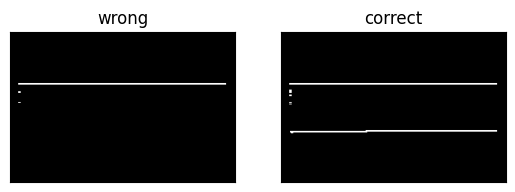

In [10]:
# sobel operators (can play around with x, y & operators type[ksize])

# wrong way
sobelx_8u = cv.Sobel(th, cv.CV_8U, 0, 1, ksize=-1)

# correct way
sobelx_32f = cv.Sobel(th, cv.CV_32F, 0, 1, ksize=-1)
sobelx = cv.convertScaleAbs(sobelx_32f) # absolute and convert to uint 8

plt.subplot(121), plt_img(sobelx_8u, "wrong")
plt.subplot(122), plt_img(sobelx, "correct")
plt.show()

### combine x and y edges
$$ \sqrt{Ix^2 + Iy^2}$$

Default: $$ |Ix|+ |Iy|$$

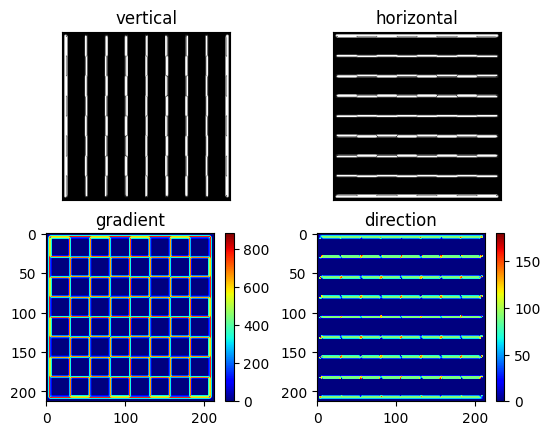

In [11]:
img = cv.imread("images/chessboard.png", 0)

#sobel x and y
sobelx_32f = cv.Sobel(img, cv.CV_32F, 1, 0)
sobelx = cv.convertScaleAbs(sobelx_32f)
sobely_32f = cv.Sobel(img, cv.CV_32F, 0, 1)
sobely = cv.convertScaleAbs(sobely_32f)

#gradient and direction
gradient = cv.magnitude(sobelx_32f, sobely_32f)
direction = cv.phase(sobelx_32f, sobely_32f, angleInDegrees = True) % 180

plt.subplot(221), plt_img(sobelx, "vertical")
plt.subplot(222), plt_img(sobely, "horizontal")
plt.subplot(223), plt.imshow(gradient, cmap = "jet"), plt.title("gradient")
plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap = "jet"), plt.title("direction")
plt.colorbar()
plt.show()

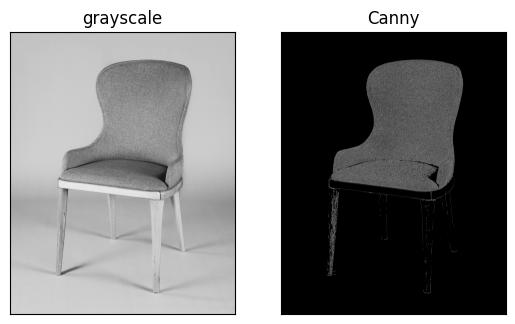

In [12]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 100, 300)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")

plt.show()

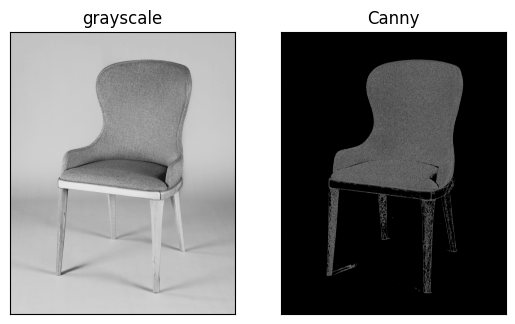

In [13]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 30, 150) 

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")

plt.show()

## Exercise
Create a trackibar that contril the hyeterisis thresholds and display the resulting images from the changes in the threshold

In [14]:
img = cv.imread("images/boat.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ratio = 2.5
trackbar_name = "Th1"
wn = "Canny"
ksize = 3

def cannyThreshold(val):
    
    """ Trackbar callback function"""
    edge = cv.Canny(gray, val, ratio * val, apertureSize = ksize)
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbar_name, wn, 10, 100, cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

In [15]:
def auto_canny(img, method, sigma = 0.33):
    """Args:
    img: grayscale image
    method: median, otsu, triangle
    signma = 0.33*(default)"""
    
    
    if (method == "median"):
        Th = np.median(img)
    elif (method == "otsu"):
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
    elif (method == "triangle"):
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
    else:
        raise Exception("Method specified unavaliable")
        
    lowTh = (1-sigma) * Th
    highTh = (1-sigma) * Th 
    
    return cv.Canny(img, lowTh, highTh)

### Contour detection

In [16]:
rect = np.zeros((256, 256), dtype = np.uint8)

cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

show_img("rect", rect)

In [17]:
contours,_ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

len(contours)

1

In [18]:
# points that encode the location of object
contours

(array([[[ 25,  25]],
 
        [[ 25, 231]],
 
        [[231, 231]],
 
        [[231,  25]]], dtype=int32),)

In [19]:
#load image
img_bgr = cv.imread("images/monitor.jfif")
img = cv.imread("images/monitor.jfif", 0)

#threshold
th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("threshold", th)

contours,_ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #button with consider as seperate contours

In [20]:
len(contours)

12

In [21]:
cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 1)

show_img("contours", img_bgr)

In [22]:
# RETR_EXTERNAL
contours,_ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy, contours, -1, (0, 255, 0), 1)
show_img("contours", img_bgr_copy)

In [23]:
len(contours)

1

In [24]:
# RETR_TREE
contours,_ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [25]:
len(contours)

12

In [26]:
#contours with maximum number of points
length = [len(c) for c in contours]
contour_largest = contours[np.argmax(length)]

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy, contour_largest, -1, (0, 255, 0), 1)

show_img("contours", img_bgr_copy)

In [27]:
print(cv.__version__)  #contour features open cv (google)

4.8.0


In [28]:
cnt = contour_largest

## Contour features

In [29]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [30]:
#centroid (center of mass)

cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])

print(f"the centroid of monitor: {(cx,cy)}")

the centroid of monitor: (105, 103)


In [31]:
# area and perimeter
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)

print(f"The area of monitor: {area}")
print(f"The perimeter of monitor: {peri:.3f}")

The area of monitor: 37113.5
The perimeter of monitor: 1056.777


In [32]:
remote = cv.imread("images/remote-controller.webp")

show_img("img", remote)

In [33]:
#  resize -> grayscale -> bilateral filter -> edge detection -> find contour -> contour featues

factor = 300 / img.shape[1]
remote = cv.resize(remote, None, fx = factor, fy = factor)
gray = cv.cvtColor(remote, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method = "triangle")

show_img("edge", edge)

In [34]:
# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

#area
contours = sorted(contours, key = cv.contourArea, reverse = True)[:5]
screen = None
remote_copy = remote.copy()

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx)==4:
        screen = c
        break
        
cv.drawContours(remote_copy, [screen], -1, (255, 0, 255), 2)
show_img("screen", remote_copy)

Circularity:
    
 $$circularity = \frac{4 \times \pi \times Area}{Perimeter^2}$$  

### Demo on red object detector

In [35]:
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (10, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam detected")
    
#factor
fixed_width = min_area = 500
factor = fixed_width / cap.get(3)   #frame width
kernel = np.ones((3,3), dtype = np.uint8)

while(1):
    ret, frame = cap.read()
    
    if not ret:
        print ("No frame received")
        break
        
        
    # resize, blur, change to hsv, inRange, mask integration, morphological
    #operation, find contour, bounding box
    
    resized = cv.resize(frame, None, fx = factor, fy = factor)
    blur = cv.GaussianBlur(resized, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    
    #supress noise
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations = 2)
    
    #find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    bbs = []
    centroids = []
    
    for c in contours:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            M = cv.moments(c)
            cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
            centroids.append((cx, cy))
            bbs.append(bb)
            
    for bb, centroid in zip(bbs, centroids):
        x, y, w, h = bb
        cv.rectangle(resized, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv.circle(resized, centroid, 2, (255, 0, 0), -1)
            
    cv.imshow("red object", resized)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
            
cv.destroyAllWindows()
cap.release()
            

## Weekly Exercise

### Exercise 1
Experiment with different edge detectors: Sobel, Laplacian, Prewitt, Scharr derivatives and Canny operators( all with aperture size of 3) on image named 'pineapple.jfif'. Comment on the results

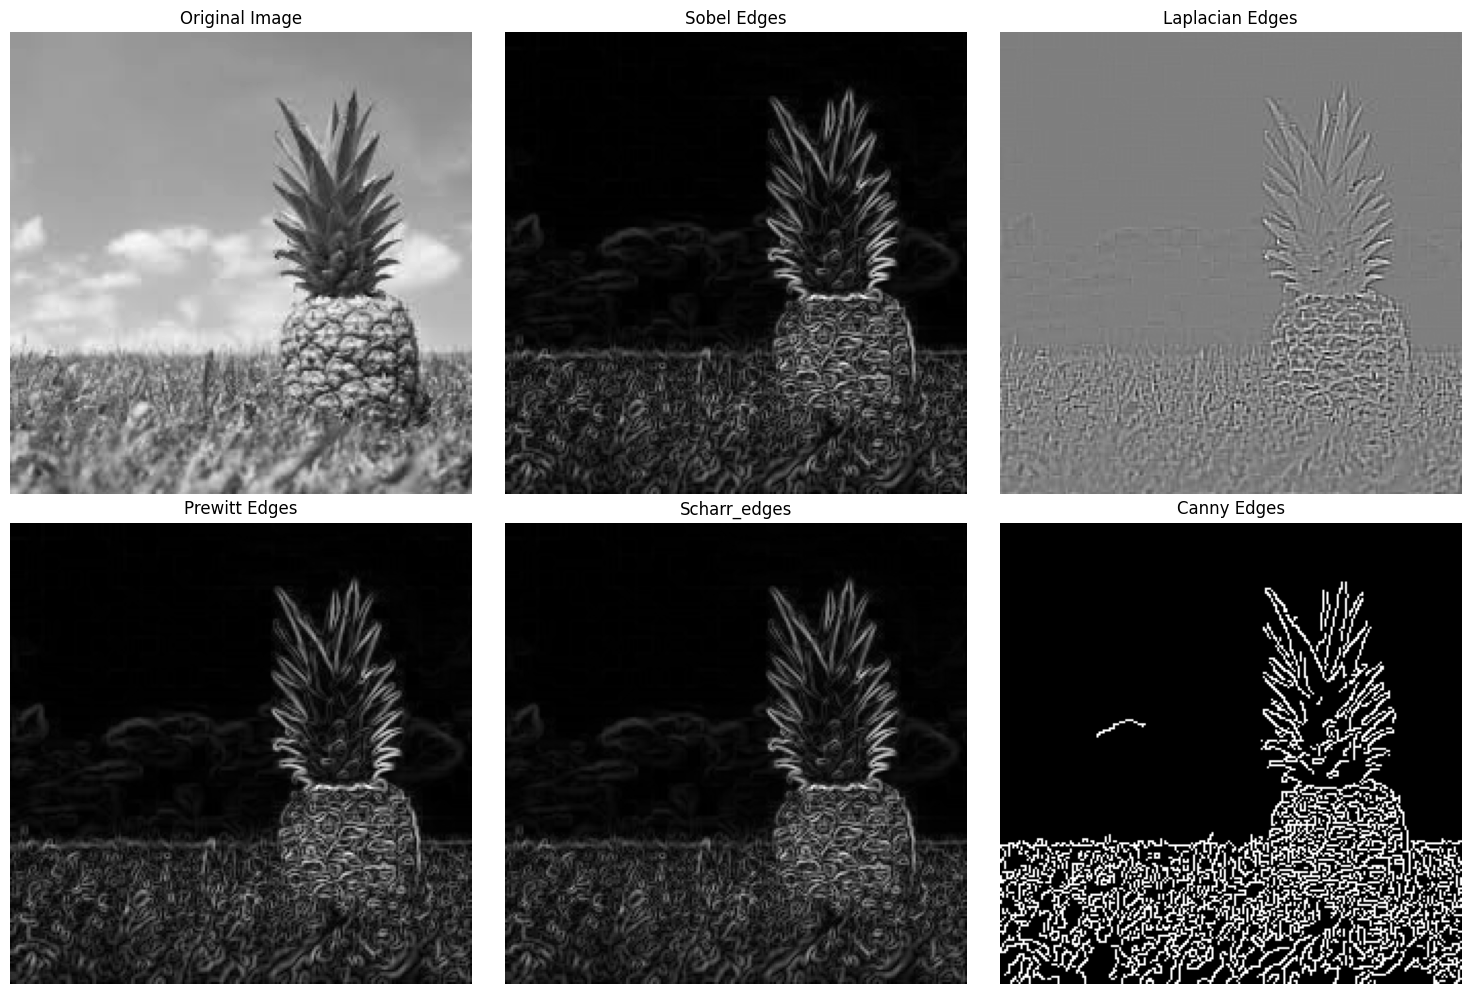

In [36]:
# Load the image
pineapple = cv.imread("images/pineapple.jfif", 0)

# Apply sobel edge detector
sobel_x = cv.Sobel(pineapple, cv.CV_32F, 1, 0, ksize = 3)
sobel_y = cv.Sobel(pineapple, cv.CV_32F, 0, 1, ksize = 3)
sobel_edges = cv.magnitude(sobel_x, sobel_y)

# Apply laplacian edge detector
laplacian_edges = cv.Laplacian(pineapple, cv.CV_32F, ksize = 3)

# Apply Prewitt edge detector
prewitt_kernel_x = cv.getDerivKernels(1, 0, 3, normalize = True)
prewitt_kernel_y = cv.getDerivKernels(0, 1, 3, normalize = True)
prewitt_x = cv.filter2D(pineapple, cv.CV_32F, prewitt_kernel_x[0] @ prewitt_kernel_x[1].T)
prewitt_y = cv.filter2D(pineapple, cv.CV_32F, prewitt_kernel_y[0] @ prewitt_kernel_y[1].T)
prewitt_edges = cv.magnitude(prewitt_x, prewitt_y)

# Apply Scharr
scharr_x = cv.Scharr(pineapple, cv.CV_32F, 1, 0)
scharr_y = cv.Scharr(pineapple, cv.CV_32F, 0, 1)
scharr_edges = cv.magnitude(scharr_x, scharr_y)

# Apply Canny edge detector
canny_edges = cv.Canny(pineapple, threshold1 = 100, threshold2 = 200, apertureSize = 3)

# Display
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(pineapple, cmap = "gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(232)
plt.imshow(sobel_edges, cmap = "gray")
plt.title("Sobel Edges")
plt.axis("off")

plt.subplot(233)
plt.imshow(laplacian_edges, cmap = "gray")
plt.title("Laplacian Edges")
plt.axis("off")

plt.subplot(234)
plt.imshow(prewitt_edges, cmap = "gray")
plt.title("Prewitt Edges")
plt.axis("off")

plt.subplot(235)
plt.imshow(scharr_edges, cmap = "gray")
plt.title("Scharr_edges")
plt.axis("off")

plt.subplot(236)
plt.imshow(canny_edges, cmap = "gray")
plt.title("Canny Edges")
plt.axis("off")

plt.tight_layout()
plt.show()

# Comments:
# For Sobel, Prewitt and Scharr Edge detector, they are almost the same.
# They have thicker edges and also sensitive to noise
# For Laplacia Edge Detector, the edges is thinner but sensitive to noise
# Canny edge detector have the thinnest edges and also less sensitive to noise compare with others

### Exercise 2
Write a program to identify the white object (probably laptop) present in the image 'electronic.jfif'. Draw bounding boxes on the objects.

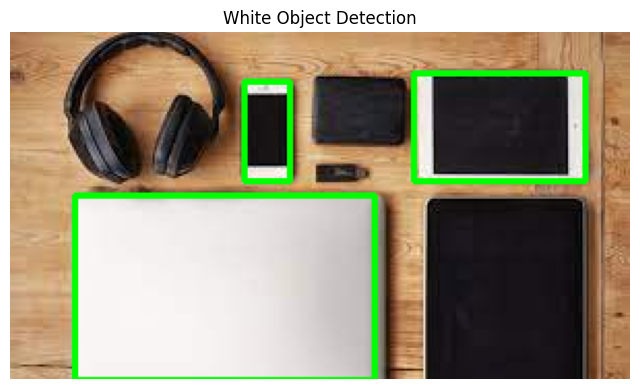

In [37]:
#Load the image
electronic = cv.imread("images/electronic.jfif")

#convert to grayscale
gray = cv.cvtColor(electronic, cv.COLOR_RGB2GRAY)

# Apply thresholding to isolate white areas
_, threshold = cv.threshold(gray, 183, 255, cv.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv.findContours(threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

electronic_copy = electronic.copy()

# Iterate through contours can draw bounding box
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    if w>5 and h>5: # filter out small areas to avoid the noise
        cv.rectangle(electronic_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
# Display
plt.figure(figsize = (8, 6))
plt.imshow(cv.cvtColor(electronic_copy,cv.COLOR_RGB2BGR))
plt.title("White Object Detection")
plt.axis("off")
plt.show()

In [38]:
##Load the image
#electronic = cv.imread("images/electronic.jfif")
#
##convert to grayscale
#gray = cv.cvtColor(electronic, cv.COLOR_RGB2GRAY)
#
## Apply Gaussian Blur
#blur = cv.bilateralFilter(gray, 7, 75, 75)
#
## Apply canny edge detector
#edge = auto_canny(blur, method = "triangle")
#
#show_img("edge", edge)
#contours, _ = cv.findContours(edge, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#
## Filter
#min_area = 500
#white = []
#
#for contour in contours:
#    area = cv.contourArea(contour)
#    if area > min_area:
#        x, y, w, h = cv.boundingRect(contour)
#        white.append((x, y, w, h))
#        cv.rectangle(electronic, (x, y), (x+w, y+h), (255, 0, 0),2)
#    
## Display
#plt.figure(figsize = (8, 6))
#plt.imshow(electronic)
#plt.title("White Object Detection")
#plt.axis("off")
#plt.show()

### Exercise 3
Isolate the clock with the aid of edge detection and contours' properties. The example result should be as follows:

In [39]:
# Load the image
clock = cv.imread("images/clock.jpg")

factor = 300 / clock.shape[1]
clock = cv.resize(clock, None, fx = factor, fy = factor)
gray = cv.cvtColor(clock, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method = "triangle")

show_img("edge", edge)

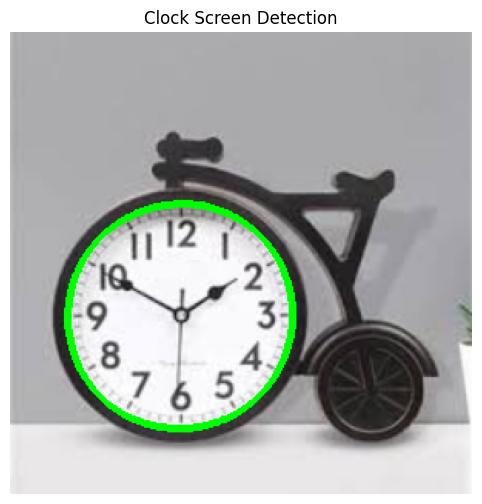

In [40]:
# find the contour
contours, _ =cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# area
contours = sorted(contours, key = cv.contourArea, reverse = True)[:5]
screen = None
clock_copy = clock.copy()

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx) == 4:
        screen = c
        break
        
cv.drawContours(clock_copy, [screen], -1, (0, 255, 0), 3)

# Display
plt.figure(figsize = (8, 6))
plt.imshow(cv.cvtColor(clock_copy,cv.COLOR_RGB2BGR))
plt.title("Clock Screen Detection")
plt.axis("off")
plt.show()